In [49]:
import pandas as pd


In [85]:
df = pd.read_csv("data/train/train.csv")
df = df.drop(["race"],axis = 1)
df

,id,gender,age,path
0,000001,female,45,000001_female_Asian_45
1,000002,female,52,000002_female_Asian_52
2,000004,male,54,000004_male_Asian_54
3,000005,female,58,000005_female_Asian_58
4,000006,female,59,000006_female_Asian_59
...,...,...,...,...
2695,006954,male,19,006954_male_Asian_19
2696,006955,male,19,006955_male_Asian_19
2697,006956,male,19,006956_male_Asian_19
2698,006957,male,20,006957_male_Asian_20


In [86]:
# 데이터 전처리

#여자 -> 남자
ids = ["006359", "006360", "006361", "006362", "006363", "006364"]

df.loc[df[df["id"].isin(ids)].index, "gender"] = "male"

#남자 -> 여자
ids = ["001498-1", "004432"]
df.loc[df[df["id"].isin(ids)].index, "gender"] = "female"

In [87]:
# 데이터 유효성 검사.

import glob

train_peoples_path = "./data/train/images/*"
people_paths = glob.glob(train_peoples_path)
people_names = [name.split("/")[-1] for name in people_paths ]

#길이 비교
print(len(people_names), len(df["path"]))
#중복 문자열 존재하는지 비교
print(len(set(people_names)), len(set(df["path"])))
#불일치 문자열 존재하는지 체크
print(len(set(people_names) - set(df["path"])))

2700 2700
2700 2700
0


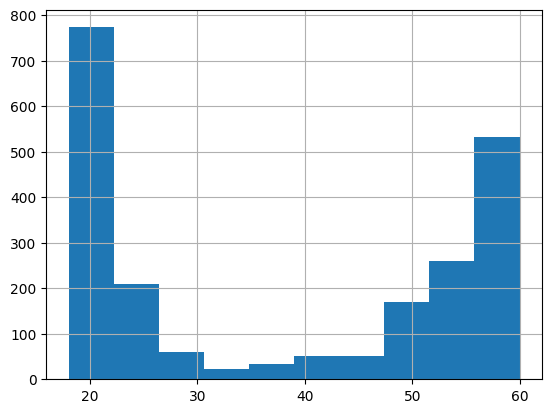

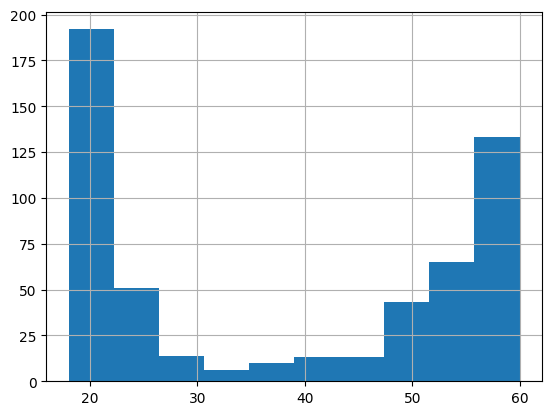

In [95]:
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

raw_data = df
for train_index, test_index in split.split(raw_data, raw_data["age"]):
    strat_train_set = raw_data.loc[train_index]
    strat_test_set = raw_data.loc[test_index]

train_df = strat_train_set
valid_df = strat_test_set
strat_train_set["age"].hist()
plt.show()
strat_test_set["age"].hist()
plt.show()

In [96]:
def labeling(df, folder_path):
    temp = pd.DataFrame()
    
    path_list = []
    full_path_list = [] 
    state_list = []
    for path in df["path"]:
        #사람 폴더에서 이미지 경로 받기.
        imgs = glob.glob(folder_path + "/" + path + "/*")
        
        path_list.extend([path]*7)
        full_path_list.extend([full_path for full_path in imgs])
        state_list.extend([full_path.split("/")[-1].split(".")[0] for full_path in imgs])
  
    temp["path"] = path_list
    temp["img_path"] = full_path_list
    temp["state"] = state_list
    return temp

mask_state_train_df = labeling(train_df, "data/train/images")  

mask_state_valid_df = labeling(valid_df, "data/train/images") 

In [97]:
def merge_df(df, mask_state_df):
    return_df = pd.merge(df, mask_state_df, how= "outer", on = "path")
    # print(return_df)
    return_df.loc[return_df.query("state == 'incorrect_mask'").index, "state"] = "incorrect"

    # 라벨링
    return_df["label"] = 0
    return_df.loc[return_df.query("state == 'incorrect'").index, "label"] += 6
    return_df.loc[return_df.query("state == 'normal'").index, "label"] += 12

    return_df.loc[return_df.query("gender == 'female'").index, "label"] += 3

    return_df.loc[return_df.query("30 <= age < 60 ").index, "label"] += 1
    return_df.loc[return_df.query("age == 60 ").index, "label"] += 2


    # valid_df = return_df.iloc[200:]
    # return_df = return_df.iloc[:200]

    return_df["c_gender"] = 0
    return_df.loc[return_df.query("gender == 'male'").index, "c_gender"] = 1

    return_df["c_state"] = 0
    return_df.loc[return_df.query("state == 'incorrect'").index, "c_state"] = 1
    return_df.loc[return_df.query("state == 'normal'").index, "c_state"] = 2

    return_df["c_age"] = 0
    return_df.loc[return_df.query("30 <= age < 60 ").index, "c_age"] = 1
    return_df.loc[return_df.query("age == 60 ").index, "c_age"] = 2
    
    
    label_dict = {0: "마스크쓴 남성 청년",
              1: "마스크쓴 남성 중년",
              2: "마스크쓴 남성 노년",
              3: "마스크쓴 여성 청년",
              4: "마스크쓴 여성 중년",
              5: "마스크쓴 여성 노년",
              
              6: "잘못쓴 남성 청년",
              7: "잘못쓴 남성 중년",
              8: "잘못쓴 남성 노년",
              9: "잘못쓴 여성 청년",
              10: "잘못쓴 여성 중년",
              11: "잘못쓴 여성 노년",
              
              12: "안쓴 남성 청년",
              13: "안쓴 남성 중년",
              14: "안쓴 남성 노년",
              15: "안쓴 여성 청년",
              16: "안쓴 여성 중년",
              17: "안쓴 여성 노년",
    }
    return_df["label_check"] = return_df["label"].replace(label_dict)
    return return_df

train_df = merge_df(train_df, mask_state_train_df)
 
valid_df = merge_df(valid_df, mask_state_valid_df)

In [98]:
valid_df.sample(20)[["gender","age","state","label_check"]]

,gender,age,state,label_check
2947,male,19,incorrect,잘못쓴 남성 청년
1464,male,18,mask2,마스크쓴 남성 청년
1815,female,24,normal,안쓴 여성 청년
3284,male,51,mask2,마스크쓴 남성 중년
2408,female,50,incorrect,잘못쓴 여성 중년
2811,male,19,mask4,마스크쓴 남성 청년
1482,male,58,mask1,마스크쓴 남성 중년
242,female,48,mask4,마스크쓴 여성 중년
3696,male,20,incorrect,잘못쓴 남성 청년
823,female,20,mask4,마스크쓴 여성 청년


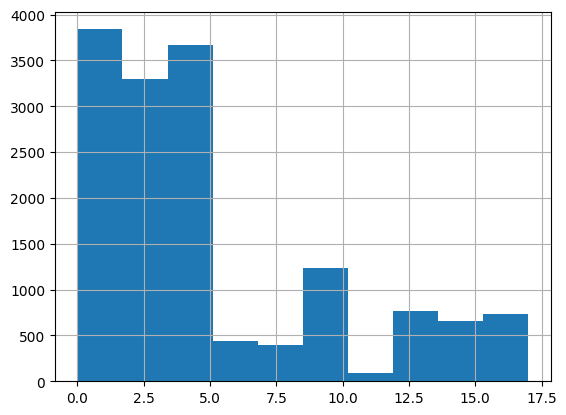

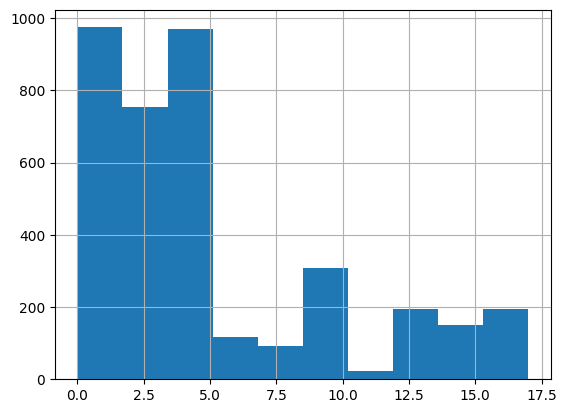

In [99]:
import matplotlib.pyplot as plt

train_df["label"].hist()
plt.show()
valid_df["label"].hist()
plt.show()

# 이미지 데이터셋 생성

In [100]:
train_df

,id,gender,age,path,img_path,state,label,c_gender,c_state,c_age,label_check
0,000531,female,56,000531_female_Asian_56,data/train/images/000531_female_Asian_56/incor...,incorrect,10,0,1,1,잘못쓴 여성 중년
1,000531,female,56,000531_female_Asian_56,data/train/images/000531_female_Asian_56/mask2...,mask2,4,0,0,1,마스크쓴 여성 중년
2,000531,female,56,000531_female_Asian_56,data/train/images/000531_female_Asian_56/norma...,normal,16,0,2,1,안쓴 여성 중년
3,000531,female,56,000531_female_Asian_56,data/train/images/000531_female_Asian_56/mask3...,mask3,4,0,0,1,마스크쓴 여성 중년
4,000531,female,56,000531_female_Asian_56,data/train/images/000531_female_Asian_56/mask4...,mask4,4,0,0,1,마스크쓴 여성 중년
...,...,...,...,...,...,...,...,...,...,...,...
15115,000024,female,58,000024_female_Asian_58,data/train/images/000024_female_Asian_58/norma...,normal,16,0,2,1,안쓴 여성 중년
15116,000024,female,58,000024_female_Asian_58,data/train/images/000024_female_Asian_58/mask3...,mask3,4,0,0,1,마스크쓴 여성 중년
15117,000024,female,58,000024_female_Asian_58,data/train/images/000024_female_Asian_58/mask4...,mask4,4,0,0,1,마스크쓴 여성 중년
15118,000024,female,58,000024_female_Asian_58,data/train/images/000024_female_Asian_58/mask1...,mask1,4,0,0,1,마스크쓴 여성 중년


In [101]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import albumentations as A
import albumentations.pytorch
import cv2

from torchvision import transforms

# transform = transforms.Compose([
#     transforms.CenterCrop((450, 250)),
#     transforms.ToTensor()
#     ,
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Declare an augmentation pipeline
album_transform = A.Compose([
    A.CenterCrop(width=300, height=350),
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(),
    A.pytorch.transforms.ToTensorV2()
])

valid_transform = A.Compose([
    A.CenterCrop(width=300, height=350),
    A.Resize(256,256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.HueSaturationValue(),
    A.pytorch.transforms.ToTensorV2()
])

class Maskset(Dataset):
    def __init__(self, df, transform, label = "label"):
        self.df = df
        self.transform = transform
        self.label = label
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        raw_image = cv2.imread(self.df["img_path"].iloc[idx])
        image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
        augmented = self.transform(image=image) 
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        x = augmented['image']
        y = torch.tensor(self.df[self.label].iloc[idx])
        return (x/255).type(torch.float), y

    

In [104]:
import numpy as np
from torch.utils.data import WeightedRandomSampler
import torch

labes_unique, counts = np.unique(train_df["label"], return_counts = True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in train_df["label"]]
sampler = WeightedRandomSampler(example_weights, len(train_df["label"]))
# class_weights

In [107]:
BATCH_SIZE = 32
train_set_dict = {}
valid_set_dict = {}
train_loader_dict = {}
valid_loader_dict = {}

for label in ["label", "c_age", "c_gender", "c_state"]:    
    train_set_dict[label] = Maskset(train_df, album_transform, label)
    valid_set_dict[label] = Maskset(valid_df, valid_transform, label)

    train_loader_dict[label] = DataLoader(train_set_dict[label], num_workers=4, batch_size=BATCH_SIZE, drop_last = True, sampler = sampler)
    valid_loader_dict[label] = DataLoader(valid_set_dict[label], num_workers=4, batch_size=BATCH_SIZE, drop_last = True, shuffle=True)


In [108]:
# print(len(train_loader.dataset), len(valid_loader.dataset))
print(len(train_loader_dict["label"].dataset), len(valid_loader_dict["label"].dataset))

15120 3780


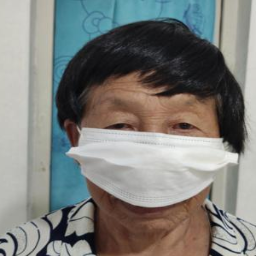

In [112]:
transforms.ToPILImage()(next(iter(train_loader_dict["label"]))[0][0])

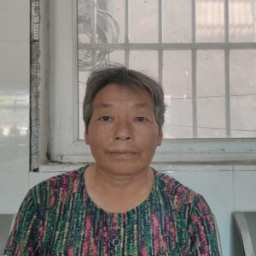

In [113]:
transforms.ToPILImage()(next(iter(valid_loader_dict["label"]))[0][0])

In [37]:
# from facenet_pytorch import InceptionResnetV1

# # For a model pretrained on VGGFace2
# model = InceptionResnetV1(pretrained='vggface2')

In [114]:
# age
import timm
from PIL import Image
from torchvision import transforms
from torch import nn
import torchvision.models as models
import torch
from tqdm.notebook import tqdm 

import math

from torch import optim

from sklearn.metrics import f1_score

NUM_EPOCH = 10
LEARNING_RATE = 0.0002

def train_model(model, train_loader, valid_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     device = "cpu"
    
    model.to(device)

    dataloaders = {
        "train" : train_loader,
        "test" : valid_loader
    }

    loss_fn = torch.nn.CrossEntropyLoss()   # 비용 함수에 소프트맥스 함수 포함되어져 있음.
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
#     scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    best_test_accuracy = 0.
    best_test_loss = 9999.

    for epoch in range(NUM_EPOCH):
        for phase in ["train", "test"]:
            running_loss = 0.
            running_acc = 0.
            epoch_f1 = 0
            n_iter = 0
            if phase == "train":
                model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
            elif phase == "test":
                model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

            for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):

                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함
                with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                    logits = model(images)
                    _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                    loss = loss_fn(logits, labels)

                    if phase == "train":
                        loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                        optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
                        scheduler.step() 

                running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
                running_acc += torch.sum(preds == labels) # 한 Batch에서의 Accuracy 값 저장
                epoch_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
                n_iter += 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)
            epoch_f1 = epoch_f1/n_iter
            
            print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, 평균 f1 : {epoch_f1:.4f}\n\n")

        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss

    print("학습 종료!")
    print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")
    return model



In [116]:
label = "c_age"
age_model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes= 3)
age_model = train_model(age_model, train_loader_dict[label],  valid_loader_dict[label])

In [ ]:
import datetime
now = datetime.datetime.now()
# print(now)          # 2015-04-19 12:11:32.669083
nowDate = now.strftime('%m%d_%H%M')
print(nowDate)      # 2015-04-19
torch.save(age_model, nowDate + "age_resnext.pt")

In [55]:
label = "c_state"
state_model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes= 3)
state_model = train_model(state_model, train_loader_dict[label],  valid_loader_dict[label])


현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.029, 평균 Accuracy : 0.991, 평균 f1 : 0.9920



현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.010, 평균 Accuracy : 0.994, 평균 f1 : 0.9950



현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.012, 평균 Accuracy : 0.996, 평균 f1 : 0.9964



현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.010, 평균 Accuracy : 0.993, 평균 f1 : 0.9950



현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.005, 평균 Accuracy : 0.998, 평균 f1 : 0.9985



현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.004, 평균 Accuracy : 0.994, 평균 f1 : 0.9982



현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.998, 평균 f1 : 0.9985



현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.015, 평균 Accuracy : 0.991, 평균 f1 : 0.9929



현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.003, 평균 Accuracy : 0.998, 평균 f1 : 0.9992



현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.001, 평균 Accuracy : 0.995, 평균 f1 : 0.9997



현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.001, 평균 Accuracy : 0.999, 평균 f1 : 0.9998



현재 epoch-5의 test-데이터 셋에서 평균 Loss : 0.001, 평균 Accuracy : 0.995, 평균 f1 : 0.9997



현재 epoch-6의 train-데이터 셋에서 평균 Loss : 0.001, 평균 Accuracy : 0.999, 평균 f1 : 0.9996



현재 epoch-6의 test-데이터 셋에서 평균 Loss : 0.002, 평균 Accuracy : 0.995, 평균 f1 : 0.9983



현재 epoch-7의 train-데이터 셋에서 평균 Loss : 0.011, 평균 Accuracy : 0.997, 평균 f1 : 0.9975



현재 epoch-7의 test-데이터 셋에서 평균 Loss : 0.002, 평균 Accuracy : 0.995, 평균 f1 : 0.9996



현재 epoch-8의 train-데이터 셋에서 평균 Loss : 0.003, 평균 Accuracy : 0.998, 평균 f1 : 0.9993



현재 epoch-8의 test-데이터 셋에서 평균 Loss : 0.002, 평균 Accuracy : 0.995, 평균 f1 : 0.9988



현재 epoch-9의 train-데이터 셋에서 평균 Loss : 0.007, 평균 Accuracy : 0.997, 평균 f1 : 0.9978



현재 epoch-9의 test-데이터 셋에서 평균 Loss : 0.002, 평균 Accuracy : 0.995, 평균 f1 : 0.9991
학습 종료!
최고 accuracy : 0.9953439235687256, 최고 낮은 loss : 0.0008553585564237514


In [56]:
label = "c_gender"
gender_model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes= 2)
gender_model = train_model(gender_model, train_loader_dict[label],  valid_loader_dict[label])


현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.048, 평균 Accuracy : 0.983, 평균 f1 : 0.9829



현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.046, 평균 Accuracy : 0.979, 평균 f1 : 0.9831



현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.017, 평균 Accuracy : 0.994, 평균 f1 : 0.9944



현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.028, 평균 Accuracy : 0.987, 평균 f1 : 0.9908



현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.013, 평균 Accuracy : 0.995, 평균 f1 : 0.9956



현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.008, 평균 Accuracy : 0.993, 평균 f1 : 0.9971



현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.010, 평균 Accuracy : 0.996, 평균 f1 : 0.9969



현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.009, 평균 Accuracy : 0.992, 평균 f1 : 0.9960



현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.005, 평균 Accuracy : 0.997, 평균 f1 : 0.9983



현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.004, 평균 Accuracy : 0.995, 평균 f1 : 0.9990



현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.003, 평균 Accuracy : 0.998, 평균 f1 : 0.9989



현재 epoch-5의 test-데이터 셋에서 평균 Loss : 0.012, 평균 Accuracy : 0.992, 평균 f1 : 0.9966



현재 epoch-6의 train-데이터 셋에서 평균 Loss : 0.012, 평균 Accuracy : 0.995, 평균 f1 : 0.9962



현재 epoch-6의 test-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.993, 평균 f1 : 0.9976



현재 epoch-7의 train-데이터 셋에서 평균 Loss : 0.001, 평균 Accuracy : 0.999, 평균 f1 : 0.9997



현재 epoch-7의 test-데이터 셋에서 평균 Loss : 0.002, 평균 Accuracy : 0.995, 평균 f1 : 0.9990



현재 epoch-8의 train-데이터 셋에서 평균 Loss : 0.013, 평균 Accuracy : 0.995, 평균 f1 : 0.9957



현재 epoch-8의 test-데이터 셋에서 평균 Loss : 0.003, 평균 Accuracy : 0.995, 평균 f1 : 0.9991



현재 epoch-9의 train-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.997, 평균 f1 : 0.9978



현재 epoch-9의 test-데이터 셋에서 평균 Loss : 0.004, 평균 Accuracy : 0.995, 평균 f1 : 0.9991
학습 종료!
최고 accuracy : 0.9947090148925781, 최고 낮은 loss : 0.001759276920823299


In [57]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

test_dir = '/opt/ml/data/eval'

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)
    
    
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform)
loader = DataLoader(dataset, batch_size = 64 ,shuffle=False)



In [58]:

model = gender_model
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to("cuda")
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())

submission['gender'] = all_predictions

# # 제출할 파일을 저장합니다.
# submission.to_csv('submission.csv', index=False)
# print('test inference is done!')

In [59]:

model = age_model
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to("cuda")
        pred = model(images)
        pred = pred.argmax(dim=-1)
        #_, preds = torch.max(logits, 1)
        all_predictions.extend(pred.cpu().numpy())

submission['age'] = all_predictions

In [60]:
model = state_model
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to("cuda")
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())

submission['state'] = all_predictions

In [61]:
submission

,ImageID,ans,gender,age,state
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0,1,1,2
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0,1,1,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0,1,1,2
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0,1,1,2
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0,1,0,2
...,...,...,...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,0,1,1,0
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,0,0,1,0
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0,0,0,1
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,0,1,1,0


In [62]:
submission["ans"] = 0
submission.loc[submission.query("state == 1").index, "ans"] += 6
submission.loc[submission.query("state == 2").index, "ans"] += 12

submission.loc[submission.query("gender == 0").index, "ans"] += 3

submission.loc[submission.query("age == 1").index, "ans"] += 1
submission.loc[submission.query("age == 2 ").index, "ans"] += 2


# train_df["label"] = 0
# train_df.loc[train_df.query("state == 'incorrect'").index, "label"] += 6
# train_df.loc[train_df.query("state == 'normal'").index, "label"] += 12

# train_df.loc[train_df.query("gender == 'female'").index, "label"] += 3

# train_df.loc[train_df.query("30 <= age < 60 ").index, "label"] += 1
# train_df.loc[train_df.query("age == 60 ").index, "label"] += 2



# train_df["c_gender"] = 0
# train_df.loc[train_df.query("gender == 'male'").index, "c_gender"] = 1

# train_df["c_state"] = 0
# train_df.loc[train_df.query("state == 'incorrect'").index, "c_state"] = 1
# train_df.loc[train_df.query("state == 'normal'").index, "c_state"] = 2

# train_df["c_age"] = 0
# train_df.loc[train_df.query("30 <= age < 60 ").index, "c_age"] = 1
# train_df.loc[train_df.query("age == 60 ").index, "c_age"] = 2



In [63]:
submission

,ImageID,ans,gender,age,state
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13,1,1,2
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1,1,1,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13,1,1,2
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13,1,1,2
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,1,0,2
...,...,...,...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1,1,1,0
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4,0,1,0
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,0,0,1
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,1,1,0


In [64]:
submission[["ImageID", "ans"]].to_csv("submission_5.csv", index=False)

In [22]:
model = timm.create_model('resnext50_32x4d', pretrained=True, num_classes=18)

# model = models.resnext50_32x4d(pretrained=True)
# out_features = model.fc.out_features
# model.last = nn.Linear(out_features, 18)
# torch.nn.init.xavier_uniform_(model.last.weight)
# stdv = 1. / math.sqrt(model.last.weight.size(1))
# model.last.bias.data.uniform_(-stdv, stdv)

dataloaders = {
    "train" : train_loader_dict["label"],
    "test" : valid_loader_dict["label"]
}

loss_fn = torch.nn.CrossEntropyLoss()   # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = model(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  

                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
                    scheduler.step() 

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")

    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
        best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
        best_test_loss = epoch_loss

print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")


<ipython-input-13-e94d5b396679>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.long)
<ipython-input-13-e94d5b396679>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.long)
<ipython-input-13-e94d5b396679>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.long)
<ipython-input-13-e94d5b396679>:17: UserWarning: To copy construct 

KeyboardInterrupt: 

In [65]:

import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

test_dir = '/opt/ml/data/eval'

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)
    
    
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform)
loader = DataLoader(dataset, shuffle=False)

model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv('submission.csv', index=False)
print('test inference is done!')

test inference is done!


In [ ]:
input_image = Image.open("data/train/images/000001_female_Asian_45/mask1.jpg")

input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)
model.eval()
with torch.no_grad():
    output = model(input_batch.to("cuda"))
    
print(output)

In [ ]:
# for epoch in range(EPOCH):   # 데이터셋을 수차례 반복합니다.

#     # TRAINING
    
#     train_epoch_loss = 0
#     train_epoch_acc = 0
#     model.train()        
    
#     for X_train_batch, y_train_batch in train_loader:
        
#         X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#         print(y_train_batch)
#         optimizer.zero_grad()
        
#         y_train_pred = model(X_train_batch)
# #       print(y_train_pred)
#         train_loss = criterion(y_train_pred, y_train_batch)
# #         train_acc = multi_acc(y_train_pred, y_train_batch)
        
#         train_loss.backward()
#         optimizer.step()
        
# #         print(train_loss.item())
# #         print(type(train_loss))

#         train_epoch_loss += train_loss.item()
#         train_epoch_acc += train_acc.item()
#         break
    
#     # VALIDATION    
#     with torch.no_grad():
        
#         val_epoch_loss = 0
#         val_epoch_acc = 0
        
#         model.eval()
#         for X_val_batch, y_val_batch in valid_loader:
#             X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
#             y_val_pred = model(X_val_batch)
                        
#             val_loss = criterion(y_val_pred, y_val_batch)
#             val_acc = multi_acc(y_val_pred, y_val_batch)
            
#             val_epoch_loss += val_loss.item()
#             val_epoch_acc += val_acc.item()
    
#     loss_stats['train'].append(train_epoch_loss/len(train_loader))
#     loss_stats['val'].append(val_epoch_loss/len(valid_loader))
#     accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
#     accuracy_stats['val'].append(val_epoch_acc/len(valid_loader))
                              
#     print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(valid_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(valid_loader):.3f}')


# print('Finished Training')